In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [117]:
SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<br>

# Parameters

In [3]:
t = 70; n = 0.02; σ = 0.2; δ = 0.1; θ = 0.36
A = 1; ɛ = np.random.randn(t);

<br>

# Model

In [60]:
def solow_swan(t, n, σ, δ, θ, A, ɛ, s, c):
    """
    A Stochastic, Discrete-Time Solow-Swan Model
    
    Inputs
    ------
      t:            number of periods
      n:            population growth rate
      σ:            savings rate
      δ:            depreciation rate
      θ:            capital income share 
      A:            technology constant
      ɛ:            stochastic process 
      s:            standard deviation of shock to total factor productivity (TFP)
      c:            indicator function of black swan event, i.e., outlier TFP shock
    
    Outputs
    -------
    - Exact
      ke            capital per income
      ke_tilda:     capital per income, log deviations
      γe:           vdsv
      ye:           dvss
      λe:           csd
    - Approximation
      ke            vds
      ke_tilda:     vsd
      γe:           vdsv
      ye:           dvss
      λe:           csd
    """
    if c is False:
        c = np.zeros(t); cs = 0
    else:
        cs = 0.5
        
    # exact solution
    k_ss = ((σ*A)/(δ+n))**(1/(1-θ))
    ke = np.empty(t); ke[0] = k_ss 
    for i in range(0,t-1): ke[i+1] = ((1-δ)*ke[i]+σ*A*np.exp((c*(cs-s)+s)[i]*ɛ[i])*(ke[i]**θ))/(1+n)
    
    # approximate solution
    B = (1+θ*n-δ*(1-θ))/(1+n)
    C = (δ+n)/(1+n)
    ka_tilda = np.append([0],
                         C*np.dot(np.power(B*np.tril(np.ones(t-1)), 
                                           np.cumsum(np.ones((t-1,t-1))-np.triu(np.ones((t-1,t-1))),axis=0))
                                  -(np.ones((t-1,t-1))-np.tril(np.ones((t-1,t-1)))), 
                                  np.multiply(c*(cs-s)+s,ɛ)[:-1]))
    
    # return
    ke_tilda = np.log(ke)-np.log(k_ss) 
    ka = np.exp(ka_tilda+np.log(k_ss))
    γe = np.log(ke[1:])-np.log(ke[:-1])
    γa = np.log(ka[1:])-np.log(ka[:-1])
    ye = A*np.multiply(np.exp(np.multiply(c*(cs-s)+s,ɛ)), np.power(ke,θ))
    ya = A*np.multiply(np.exp(np.multiply(c*(cs-s)+s,ɛ)), np.power(ka,θ))
    ye_tilda = np.multiply(c*(cs-s)+s,ɛ)+np.multiply(θ, ke_tilda)
    ya_tilda = np.multiply(c*(cs-s)+s,ɛ)+np.multiply(θ, ka_tilda)
    λe = np.log(ye[1:])-np.log(ye[:-1])
    λa = np.log(ya[1:])-np.log(ya[:-1])
    
    return(
        [ke, ke_tilda, γe, ye, ye_tilda, λe],
        [ka, ka_tilda, γa, ya, ya_tilda, λa]
    )

<br>

In [5]:
exact, approx = solow_swan(t, n, σ, δ, θ, A, ɛ, 0.1, False)
ke, ke_tilda, γe, ye, ye_tilda, λe = exact
ka, ka_tilda, γa, ya, ya_tilda, λa = approx

<br>

# No Crisis

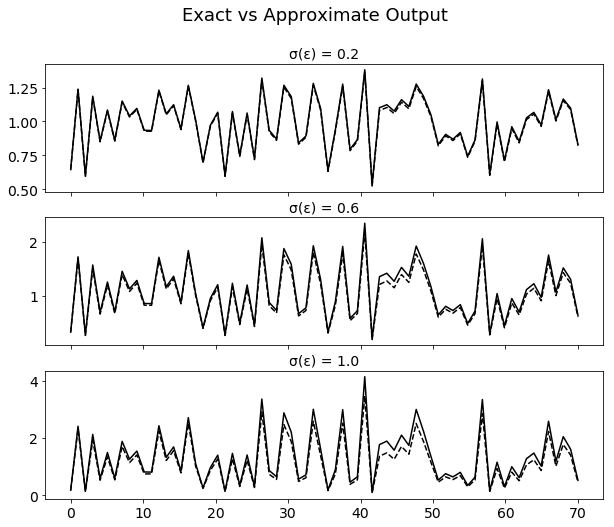

In [120]:
f, axarr = plt.subplots(3, sharex=True, figsize=(10,8))
f.suptitle('Exact vs Approximate Output')
xaxis = np.linspace(0, t, t)
#plt.figure(figsize=(10,8))
#plt.legend(loc='upper left')
#plt.xlabel("σ(ɛ)")
for i, s in enumerate(np.linspace(0.25, 1, 3)):
    axarr[i].set_title("σ(ɛ) = "+str(round(s,1)))
    axarr[i].plot(xaxis, np.exp(solow_swan(t, n, σ, δ, θ, A, ɛ, s, False)[0][4]), 'black')
    axarr[i].plot(xaxis, np.exp(solow_swan(t, n, σ, δ, θ, A, ɛ, s, False)[1][4]), 'black', linestyle = "--")
plt.show()

<br>

## Calibration

$$ \text{sd($y_h$)} = 0.0263823561094945,  \quad \text{ log differences} $$ 

In [6]:
sdh = 0.0263823561094945

In [7]:
def g1(se): return np.var(solow_swan(t, n, σ, δ, θ, A, ɛ, se, False)[0][4]) - sdh**2

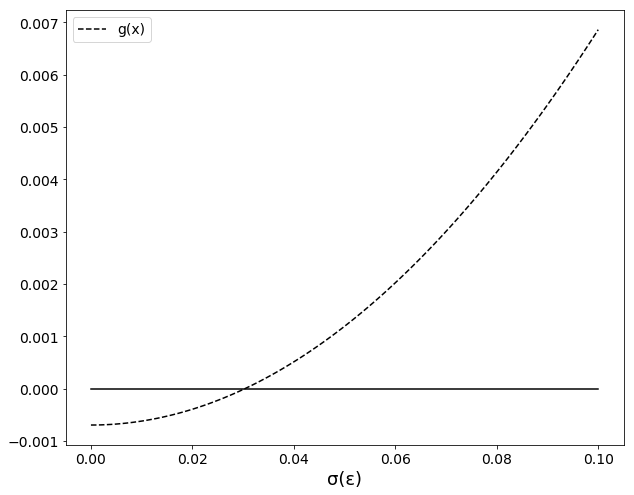

In [8]:
soi = np.linspace(0, 0.1, 100)
plt.figure(figsize=(10,8))
plt.plot(soi, soi*0, 'black')
plt.plot(soi, [g1(x) for x in soi], 'black', linestyle = "--", label='g(x)')
plt.legend(loc='upper left')
plt.xlabel("σ(ɛ)")
plt.show()

In [9]:
sr = brentq(g1, 0, 0.1)

<br>

# Visualizations

In [27]:
exact, approx = solow_swan(t, n, σ, δ, θ, A, ɛ, sr, False)
ke, ke_tilda, γe, ye, ye_tilda, λe = exact
ka, ka_tilda, γa, ya, ya_tilda, λa = approx

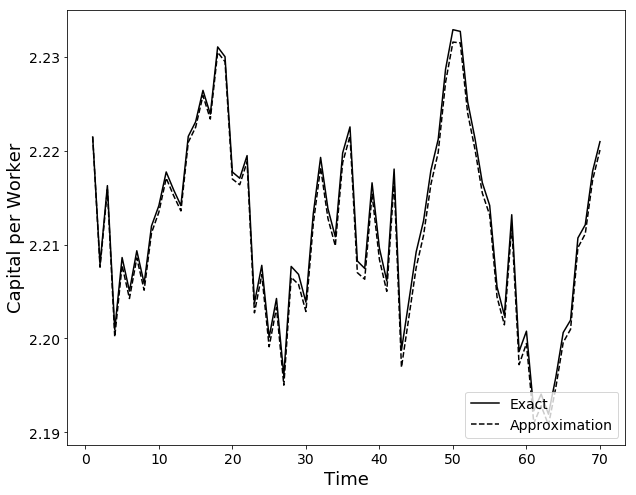

In [11]:
time = np.linspace(1, t, t)
plt.figure(figsize=(10,8))
plt.plot(time, ke, 'black', label='Exact')
plt.plot(time, ka, 'black', linestyle = "--", label='Approximation')
plt.legend(loc='lower right')
plt.ylabel("Capital per Worker")
plt.xlabel("Time")
plt.show()

<br>

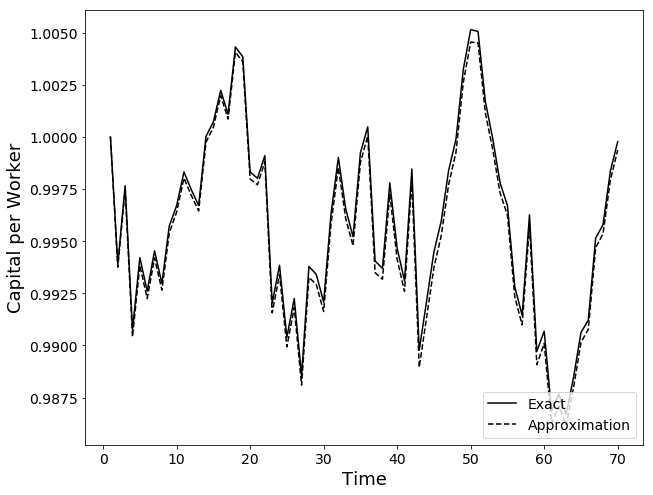

In [12]:
time = np.linspace(1, t, t)
plt.figure(figsize=(10,8))
plt.plot(time, np.exp(ke_tilda), 'black', label='Exact')
plt.plot(time, np.exp(ka_tilda), 'black', linestyle = "--", label='Approximation')
plt.legend(loc='lower right')
plt.ylabel("Capital per Worker")
plt.xlabel("Time")
plt.show()

<br>

# Crisis

In [62]:
ct = np.random.binomial(1, 0.015, t)

## Calibration

$$ \text{sd($y_h$)} = 0.0263823561094945,  \quad \text{ log differences} $$ 

0.015 e 0.5; error 0.00888699633013057

In [28]:
sdh = 0.0263823561094945

In [29]:
def g2(se): return np.var(solow_swan(t, n, σ, δ, θ, A, ɛ, se, ct)[0][3]) - sdh**2

In [75]:
cerror = np.sum(np.abs(ye-ya))
cerror

0.0074279893620332604

In [77]:
cerror= 0.00000000001

In [78]:
ct = np.random.binomial(1, 0.012, t)
while (g2(0)*g2(0.02)>0 or sum(ct)==0 or ct[0]== 1 or np.sum(np.power(solow_swan(t, n, σ, δ, θ, A, ɛ, sr, ct)[0][3]
                                                                      -solow_swan(t, n, σ, δ, θ, A, ɛ, sr, ct)[1][3],2))<cerror):

    ct = np.random.binomial(1, 0.012, t)    
sr = brentq(g2, 0, 0.1)

# Visualizations

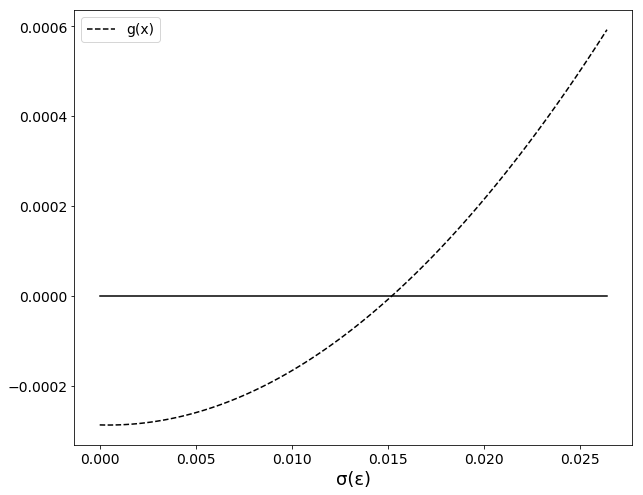

In [79]:
soi = np.linspace(0, sdh, 100)
plt.figure(figsize=(10,8))
plt.plot(soi, soi*0, 'black')
plt.plot(soi, [g2(x) for x in soi], 'black', linestyle = "--", label='g(x)')
plt.legend(loc='upper left')
plt.xlabel("σ(ɛ)")
plt.show()

In [80]:
sr = brentq(g2, 0, 0.1)

<br>

# Visualizations

In [81]:
exact, approx = solow_swan(t, n, σ, δ, θ, A, ɛ, sr, ct)
ke, ke_tilda, γe, ye, ye_tilda, λe = exact
ka, ka_tilda, γa, ya, ya_tilda, λa = approx

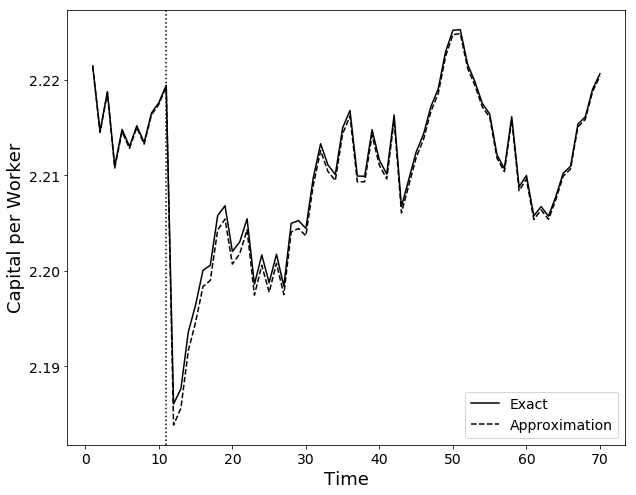

In [82]:
time = np.linspace(1, t, t)
plt.figure(figsize=(10,8))
plt.plot(time, ke, 'black', label='Exact')
plt.plot(time, ka, 'black', linestyle = "--", label='Approximation')
plt.legend(loc='lower right')
plt.ylabel("Capital per Worker")
plt.xlabel("Time")
for x in np.multiply(ct,time)[np.multiply(ct,time)!=0]: plt.axvline(x, color='black', linestyle=':')
plt.show()

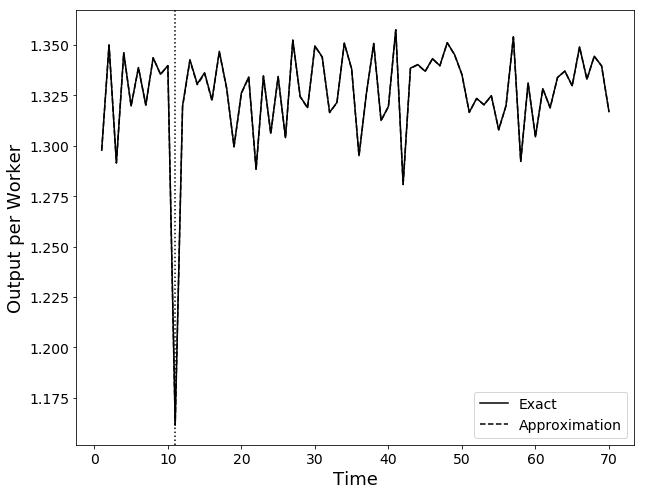

In [83]:
time = np.linspace(1, t, t)
plt.figure(figsize=(10,8))
plt.plot(time, ye, 'black', label='Exact')
plt.plot(time, ya, 'black', linestyle = "--", label='Approximation')
plt.legend(loc='lower right')
plt.ylabel("Output per Worker")
plt.xlabel("Time")
for x in np.multiply(ct,time)[np.multiply(ct,time)!=0]: plt.axvline(x, color='black', linestyle=':')
plt.show()

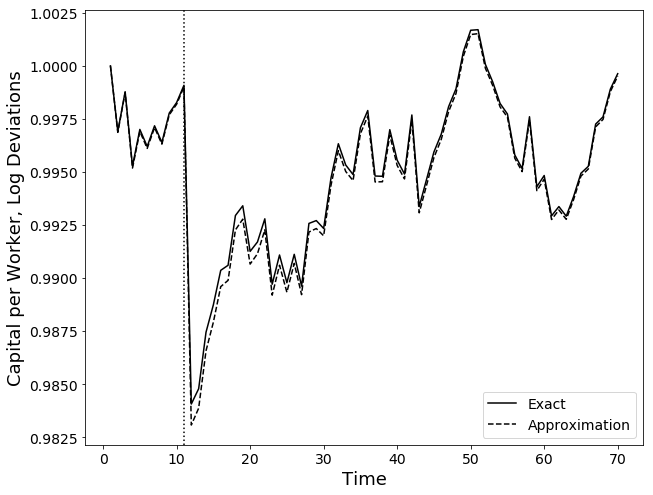

In [84]:
time = np.linspace(1, t, t)
plt.figure(figsize=(10,8))
plt.plot(time, np.exp(ke_tilda), 'black', label='Exact')
plt.plot(time, np.exp(ka_tilda), 'black', linestyle = "--", label='Approximation')
plt.legend(loc='lower right')
plt.ylabel("Capital per Worker, Log Deviations")
plt.xlabel("Time")
for x in np.multiply(ct,time)[np.multiply(ct,time)!=0]: plt.axvline(x, color='black', linestyle=':')
plt.show()

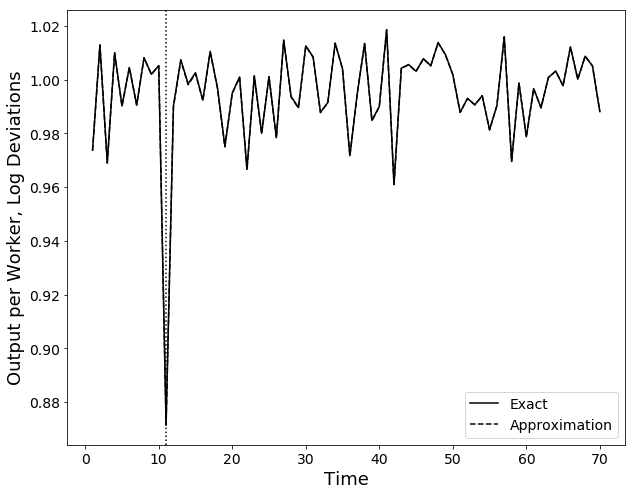

In [85]:
time = np.linspace(1, t, t)
plt.figure(figsize=(10,8))
plt.plot(time, np.exp(ye_tilda), 'black', label='Exact')
plt.plot(time, np.exp(ya_tilda), 'black', linestyle = "--", label='Approximation')
plt.legend(loc='lower right')
plt.ylabel("Output per Worker, Log Deviations")
plt.xlabel("Time")
for x in np.multiply(ct,time)[np.multiply(ct,time)!=0]: plt.axvline(x, color='black', linestyle=':')
plt.show()

<br>

<br>